In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
img_size = 380
img_crop = 256

In [4]:
# normalization parameters
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

#Applying Transformation
train_transforms = transforms.Compose([transforms.Resize((img_size,img_size)),
                                transforms.CenterCrop(img_crop),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize((img_size,img_size)),
                                      transforms.CenterCrop(img_crop),
                                      transforms.ToTensor()])

In [5]:
train_set = torchvision.datasets.ImageFolder('dataset/training', transform=train_transforms)
test_set = torchvision.datasets.ImageFolder('dataset/validation', transform=test_transforms)

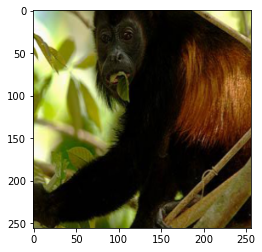

In [6]:
plt.imshow(train_set[0][0].permute(1,2,0))

In [7]:
BATCH_SIZE = 64

torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
torch.manual_seed(0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.batch_32 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.batch_64 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128, kernel_size=5, padding=2)
        self.batch_128 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256, kernel_size=5, padding=2)
        self.batch_256 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=7, padding=3)
        self.batch_512 = nn.BatchNorm2d(512)

        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.45)

        self.fc1 = nn.Linear(in_features=512*8*8, out_features=64)
        self.batch_fc = nn.BatchNorm1d(64)

        self.out = nn.Linear(in_features=64, out_features=10)

    
    def forward(self, x):

        x = self.conv1(x)
        x = self.batch_32(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.batch_64(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.batch_128(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.dropout(x)

        x = self.conv4(x)
        x = self.batch_256(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.dropout(x)

        x = self.conv5(x)
        x = self.batch_512(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.dropout(x)

        x = self.fc1(x.view(-1, 512*8*8))
        x = self.batch_fc(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.out(x)

        return x
    

In [9]:
torch.manual_seed(0)
net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (batch_32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (batch_64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (batch_512): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.45, inplace=Fals

In [10]:
EPOCHS = 60
LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

In [11]:
def train():
    
    train_loss = []
    test_loss = []

    for epoch in range(EPOCHS):
        running_loss = 0.0
        running_test_loss = 0.0
        correct_predictions = 0.0

        net.train()
        for (data, target) in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data.view(BATCH_SIZE, 3, img_crop, img_crop))
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.detach().item()

        
        with torch.no_grad():
            net.eval()
            for (data, target) in test_loader:
                data, target = data.to(device), target.to(device)
                output = net(data.view(BATCH_SIZE, 3, img_crop, img_crop))
                loss = criterion(output, target)
                running_test_loss += loss.detach().item()

                index = output.max(dim=1)[1]
                correct_predictions = correct_predictions + (index == target).sum().detach().item()

        avg_train_loss = running_loss / len(train_loader)
        train_loss.append(avg_train_loss)

        avg_test_loss = running_test_loss / len(test_loader)
        test_loss.append(avg_test_loss)

        accuracy = 100*(correct_predictions / (len(test_loader)*BATCH_SIZE))

        print('Epoch {}, Train Loss: {:.4f}, Test Loss: {:.4f}, Test Accuracy: {:.3f}'.format(epoch+1, avg_train_loss, avg_test_loss, accuracy))

        if accuracy > 75:
            return train_loss, test_loss

    return train_loss, test_loss

In [12]:
train_loss, test_loss = train()

Epoch 1, Train Loss: 2.0490, Test Loss: 3.6566, Test Accuracy: 11.719
Epoch 2, Train Loss: 1.7358, Test Loss: 3.0533, Test Accuracy: 11.328
Epoch 3, Train Loss: 1.6003, Test Loss: 2.6090, Test Accuracy: 16.406
Epoch 4, Train Loss: 1.4529, Test Loss: 2.1762, Test Accuracy: 24.609
Epoch 5, Train Loss: 1.3649, Test Loss: 2.0304, Test Accuracy: 30.469
Epoch 6, Train Loss: 1.2767, Test Loss: 2.0216, Test Accuracy: 30.469
Epoch 7, Train Loss: 1.1794, Test Loss: 1.7945, Test Accuracy: 37.500
Epoch 8, Train Loss: 1.0978, Test Loss: 1.6296, Test Accuracy: 39.844
Epoch 9, Train Loss: 1.0437, Test Loss: 1.8140, Test Accuracy: 37.891
Epoch 10, Train Loss: 0.9830, Test Loss: 1.6379, Test Accuracy: 45.703
Epoch 11, Train Loss: 0.9457, Test Loss: 1.5657, Test Accuracy: 45.703
Epoch 12, Train Loss: 0.8900, Test Loss: 1.5322, Test Accuracy: 46.094
Epoch 13, Train Loss: 0.8644, Test Loss: 1.6732, Test Accuracy: 44.141
Epoch 14, Train Loss: 0.8570, Test Loss: 1.3041, Test Accuracy: 55.078
Epoch 15, Train

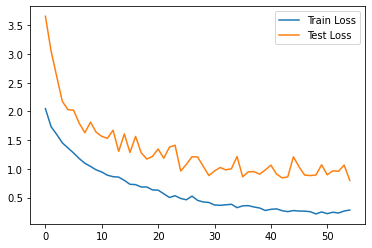

In [13]:
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()
plt.show()

In [14]:
dataset = transforms.Compose([transforms.Resize((img_size,img_size)),
                                transforms.CenterCrop(img_crop),
                                transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder('dataset/validation', transform=dataset)

<Figure size 432x288 with 0 Axes>

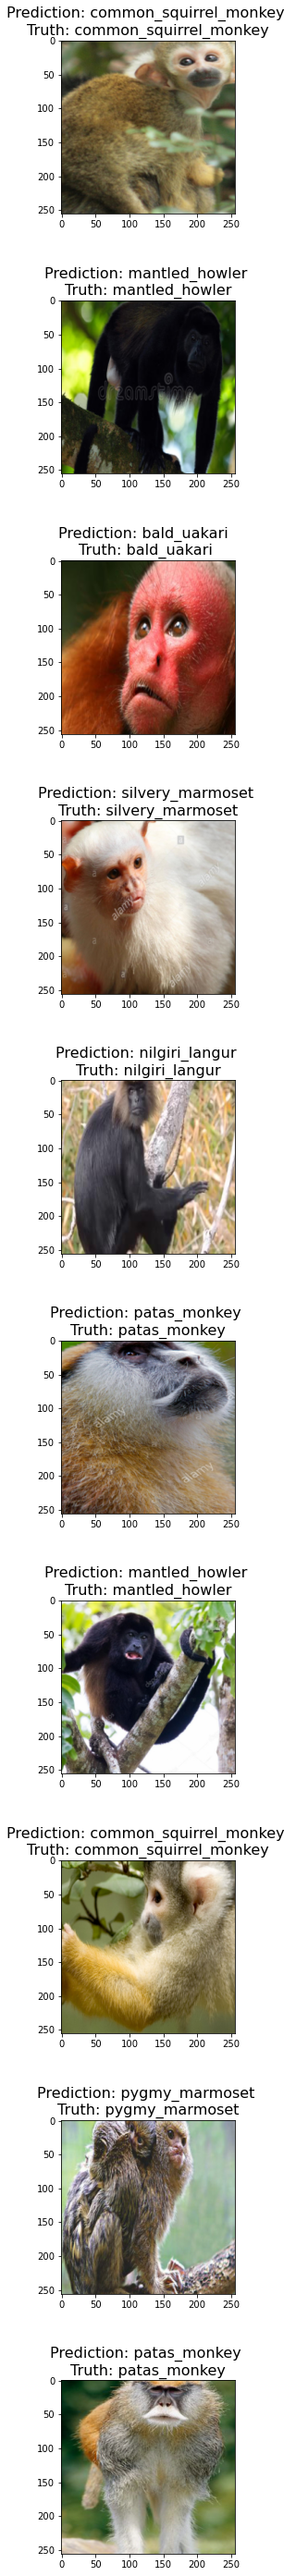

In [18]:
animal = {0: 'mantled_howler', 1: 'patas_monkey', 2: 'bald_uakari ', 3: 'japanese_macaque', 4: 'pygmy_marmoset', 5: 'white_headed_capuchin', 6: 'silvery_marmoset', 7: 'common_squirrel_monkey', 8: 'black_headed_night_monkey', 9: 'nilgiri_langur'}

n = 10

plt.figure()
fig, ax = plt.subplots(n, 1, figsize=(50, 50))
fig.subplots_adjust(hspace=0.5)

indices = list(range(272))
random.shuffle(indices)
indices = indices[:10]

for j, i in enumerate(indices):
    truth_label = dataset[i][1]

    prediction = net(dataset[i][0].view(1, 3, img_crop, img_crop).to(device))
    index = prediction.argmax().item()

    ax[j].set_title('Prediction: {} \nTruth: {}'.format(animal[index], animal[truth_label]), FontSize=16)
    ax[j].imshow(dataset[i][0].permute(1,2,0), cmap='gray_r')